<a href="https://colab.research.google.com/github/mardom/astrostatistics-2020/blob/main/NLR_GP_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arxiv.org/abs/2011.04671
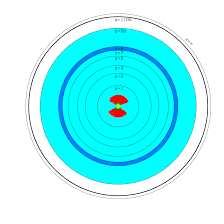

https://astrobites.org/2018/03/14/first-detection-of-the-21cm-cosmic-dawn-signal/



# Nonlinear Regression

Forcing data to correspond to a linear model through the use of coordinate transformations is a well-used trick in astronomy (e.g., the extensive use of logarithms in the astronomical literature to linearize complex relations between attributes; fitting
$y = A exp(B x)$ becomes a linear problem with $z = K + B x$, where $z = log$ y and
$K = log A$. These simplifications, while often effective, introduce other complications (including the non-Gaussian nature of the uncertainties for low signal-to-noise
data). We must, eventually, consider the case of nonlinear regression and model fitting.

In the cosmological examples described previously we have fit a series of
parametric and nonparametric models to the supernova data. Given that we know the
theoretical form of the underlying cosmological model, these models are somewhat ad hoc (e.g., using a series of polynomials to parameterize the dependence of distance modulus on cosmological redshift). In the following we consider directly fitting the cosmological model described. Solving for $\Omega_m$ and $\Omega_{\Lambda}$ is a nonlinear optimization problem requiring that we maximize the posterior,

$$p(\Omega_m, \Omega_{Lambda}| z, I) \propto \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi}\sigma_i} exp(\frac{-(\mu_i-\mu(z_i| \Omega_m, \Omega_{\Lambda} ))^2}{2\sigma_i^2})p(\Omega_m, \Omega_{\Lambda})$$

with $\mu_i$ the distance modulus for the supernova and $z_i$ the redshift. We introduced Markov chain Monte Carlo as a sampling technique that can be used for searching through parameter space. Figure 5 shows the resulting
likelihood contours for our cosmological model after applying the Metropolis–Hastings algorithm to generate the MCMC chains and integrating the chains over the parameter space.

@pickle_results: using precomputed results from 'mu_z_nonlinear.pkl'


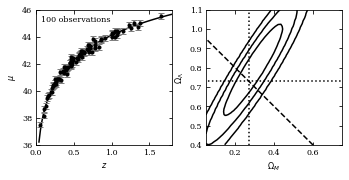

In [13]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astropy.cosmology import LambdaCDM

from astroML.datasets import generate_mu_z
from astroML.plotting.mcmc import convert_to_stdev
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Generate the data
z_sample, mu_sample, dmu = generate_mu_z(100, z0=0.3,
                                         dmu_0=0.05, dmu_1=0.004,
                                         random_state=1)


#------------------------------------------------------------
# define a log likelihood in terms of the parameters
#  beta = [omegaM, omegaL]
def compute_logL(beta):
    cosmo = LambdaCDM(H0=71, Om0=beta[0], Ode0=beta[1], Tcmb0=0)
    mu_pred = cosmo.distmod(z_sample).value
    return - np.sum(0.5 * ((mu_sample - mu_pred) / dmu) ** 2)


#------------------------------------------------------------
# Define a function to compute (and save to file) the log-likelihood
@pickle_results('mu_z_nonlinear.pkl')
def compute_mu_z_nonlinear(Nbins=50):
    omegaM = np.linspace(0.05, 0.75, Nbins)
    omegaL = np.linspace(0.4, 1.1, Nbins)

    logL = np.empty((Nbins, Nbins))

    for i in range(len(omegaM)):
        for j in range(len(omegaL)):
            logL[i, j] = compute_logL([omegaM[i], omegaL[j]])

    return omegaM, omegaL, logL


omegaM, omegaL, res = compute_mu_z_nonlinear()
res -= np.max(res)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

# left plot: the data and best-fit
ax = fig.add_subplot(121)
whr = np.where(res == np.max(res))
omegaM_best = omegaM[whr[0][0]]
omegaL_best = omegaL[whr[1][0]]
cosmo = LambdaCDM(H0=71, Om0=omegaM_best, Ode0=omegaL_best, Tcmb0=0)

z_fit = np.linspace(0.04, 2, 100)
mu_fit = cosmo.distmod(z_fit).value

ax.plot(z_fit, mu_fit, '-k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray')

ax.set_xlim(0, 1.8)
ax.set_ylim(36, 46)

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.text(0.04, 0.96, "%i observations" % len(z_sample),
        ha='left', va='top', transform=ax.transAxes)

# right plot: the likelihood
ax = fig.add_subplot(122)

ax.contour(omegaM, omegaL, convert_to_stdev(res.T),
           levels=(0.683, 0.955, 0.997),
           colors='k')

ax.plot([0, 1], [1, 0], '--k')
ax.plot([0, 1], [0.73, 0.73], ':k')
ax.plot([0.27, 0.27], [0, 2], ':k')

ax.set_xlim(0.05, 0.75)
ax.set_ylim(0.4, 1.1)

ax.set_xlabel(r'$\Omega_M$')
ax.set_ylabel(r'$\Omega_\Lambda$')

plt.show()

An alternate approach is to use the Levenberg–Marquardt (LM) algorithm to optimize the maximum likelihood estimation. LM searches for the sum-of-squares minima of a multivariate distribution through a combination of
gradient descent and Gauss–Newton optimization. 

LM is an iterative process. At each iteration LM searches for the step  that
minimizes  and then updates the regression model. The iterations cease when the step size, or change in likelihood values reaches a predefined value. t should be noted that the success of the LM algorithm often relies
on the initial guesses for the regression parameters being close to the maximum
likelihood solution (in the presence of nonlocal minima), or the likelihood function
surface being unimodal.

# Uncertainties in the Data
In the opening section we introduced the problem of regression in its most general form. Computational complexity (particularly for the case of multivariate data) led us through a series of approximations that can be used in optimizing the likelihood and the prior (e.g., that the uncertainties have a Gaussian distribution, that the independent variables are error-free, that we can control complexity of the model, and that we can express the likelihood in terms of linear functions). 

Eventually we have to face the problem that many of these assumptions no longer hold for data
in the wild. We have addressed the question of model complexity; working from linear to nonlinear regression. We now return to the question of error behavior and consider the uncertainty that is inherent in any analysis.

## Uncertainties in the Dependent and Independent Axes

In almost all real-world applications, the assumption that one variable (the indepen-
dent variable) is essentially free from any uncertainty is not valid. Both the dependent
and independent variables will have measurement uncertainties. For our example
data set we have assumed that the redshifts of the supernovas are known to a very
high level of accuracy (i.e., that we measure these redshifts spectroscopically). If,
for example, the redshifts of the supernovas were estimated based on the colors
of the supernova (or host galaxy) then the errors on the redshift estimate can
be significant. For our synthetic data we assume fractional uncertainties on the
independent variable of 10%.

The impact of errors on the “independent” variables is a bias in the derived
regression coefficients

$$y_i^*=\theta_0+ \theta_1 x_i^*$$

Now let us assume that we observe $y$ and $x$, which are noisy representations of $y^∗$
and $x^∗$ , i.e.,


$$x_i=x^*+\delta_i$$
$$y_i=y^*+\epsilon_i$$

with $\delta$ and $\epsilon$ centered normal distributions. Solving for y we get:


$$y=\theta_0+\theta_1 (x_i-\delta_i)+\epsilon_i$$

The uncertainty in $x$ is now part of the regression equation and scales with the
regression coefficients (biasing the regression coefficient). This problem is known
in the statistics literature as total least squares and belongs to the class of “errors-in-
variables” problems. A very detailed discussion of regression and the problem of uncertainties from an astronomical perspective can be found in 
https://arxiv.org/abs/1008.4686 and  https://arxiv.org/abs/1112.1745.


How can we account for the measurement uncertainties in both the independent
and dependent variables? Let us start with a simple example where we assume the
errors are Gaussian so we can write the covariance matrix as

$$\Sigma_i= 
\begin{pmatrix}
\sigma_{x_i}^2 &  \sigma_{x_iy} \\
 \sigma_{xy_i} &  \sigma_{y}^2 \\
\end{pmatrix}$$

For a straight-line regression we express the slope of the line, $\theta_1$, in terms of its
normal vector,

$$n=\begin{pmatrix}
-sin(\alpha)  \\
cos(\alpha) \\
\end{pmatrix}$$

where $\theta_1 = arctan(\alpha)$ and $\alpha$ is the angle between the line and the x-axis. The
covariance matrix projects onto this space as

$$S_i^2=n^T \Sigma_i n$$

and the distance between a point and the line is given by:

$$\Delta_i=n^T z_i+\theta_0 cos(\alpha)$$

where $z_i$ represents the data point $(x_i , y_i$). The log-likelihood is then

$$Ln (L)=-\sum_{i} \frac{\Delta_i^2}{2 S_i^2}$$

Maximizing this likelihood for the regression parameters, $\theta_0$ and $\theta_1$ is shown
in next figure, where we use the data with correlated uncertainties on the x and y components, and recover the underlying linear relation. For a single parameter
search ($θ_1$) the regression can be undertaken in a brute-force manner. As we increase
the complexity of the model or the dimensionality of the data, the computational cost will grow and techniques such as MCMC must be employed.

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164


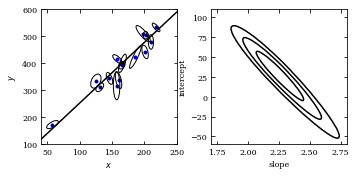

In [14]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_hogg2010test

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


#------------------------------------------------------------
# Define some convenience functions

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse pricipal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))

#------------------------------------------------------------
# We'll use the data from table 1 of Hogg et al. 2010
data = fetch_hogg2010test()
data = data[5:]  # no outliers
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']

#------------------------------------------------------------
# Find best-fit parameters
X = np.vstack((x, y)).T
dX = np.zeros((len(x), 2, 2))
dX[:, 0, 0] = sigma_x ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,
                         x0=[-1, 1])

#------------------------------------------------------------
# Plot the data and fits
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

#------------------------------------------------------------
# first let's visualize the data
ax = fig.add_subplot(121)
ax.scatter(x, y, c='k', s=9)
plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)

#------------------------------------------------------------
# plot the best-fit line
m_fit, b_fit = get_m_b(beta_fit)
x_fit = np.linspace(0, 300, 10)
ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')

ax.set_xlim(40, 250)
ax.set_ylim(100, 600)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

#------------------------------------------------------------
# plot the likelihood contour in m, b
ax = fig.add_subplot(122)
m = np.linspace(1.7, 2.8, 100)
b = np.linspace(-60, 110, 100)
logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997),
           colors='k')
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.set_xlim(1.7, 2.8)
ax.set_ylim(-60, 110)

plt.show()

# Regression That Is Robust to Outliers
A fact of experimental life is that if you can measure an attribute you can also measure
it incorrectly. Despite the increase in fidelity of survey data sets, any regression or
model fitting must be able to account for outliers from the fit. For the standard least-
squares regression the use of an L2 norm results in outliers that have substantial leverage in any fit (contributing as the square of the systematic deviation). If we knew $e(y_i |y)$ for all of the points in our sample (e.g., they are described by an exponential
distribution where we would use the L1 norm to define the error) then we would simply include the error distribution when defining the likelihood. When we do
not have a priori knowledge of $e(y_i |y)
$, things become more difficult. We can either
model $e(y_i |y)$ as a mixture model or assume a form for $e(y_i |y)$ that is less sensitive
to outliers. An example of the latter would be the adoption of the L1 norm, $\sum_i ||y_i − w_i x_i ||$, which is less sensitive to outliers than the L2 norm (and was, in fact, proposed by Rudjer Bošković prior to the development of least-squares regression by Legendre, Gauss, and others).

Minimizing the L1 norm is essentially finding the median. The drawback of this least absolute value regression is that there is no closed-form solution and we must minimize the likelihood space using an iterative approach.
Other approaches to robust regression adopt an approach that seeks to reject outliers. In the astronomical community this is usually referred to as “sigma clipping” and is undertaken in an iterative manner by progressively pruning data points that are not well represented by the model. Least-trimmed squares formalizes this,
somewhat ad hoc approach, by searching for the subset of K points which minimize $\sum_i^K 
(y_i − \theta_i x_i)^2$. For large N the number of combinations makes this search expensive.
Complementary to outlier rejection are the Theil–Sen  or the Kendall robust
line-fit method and associated techniques.

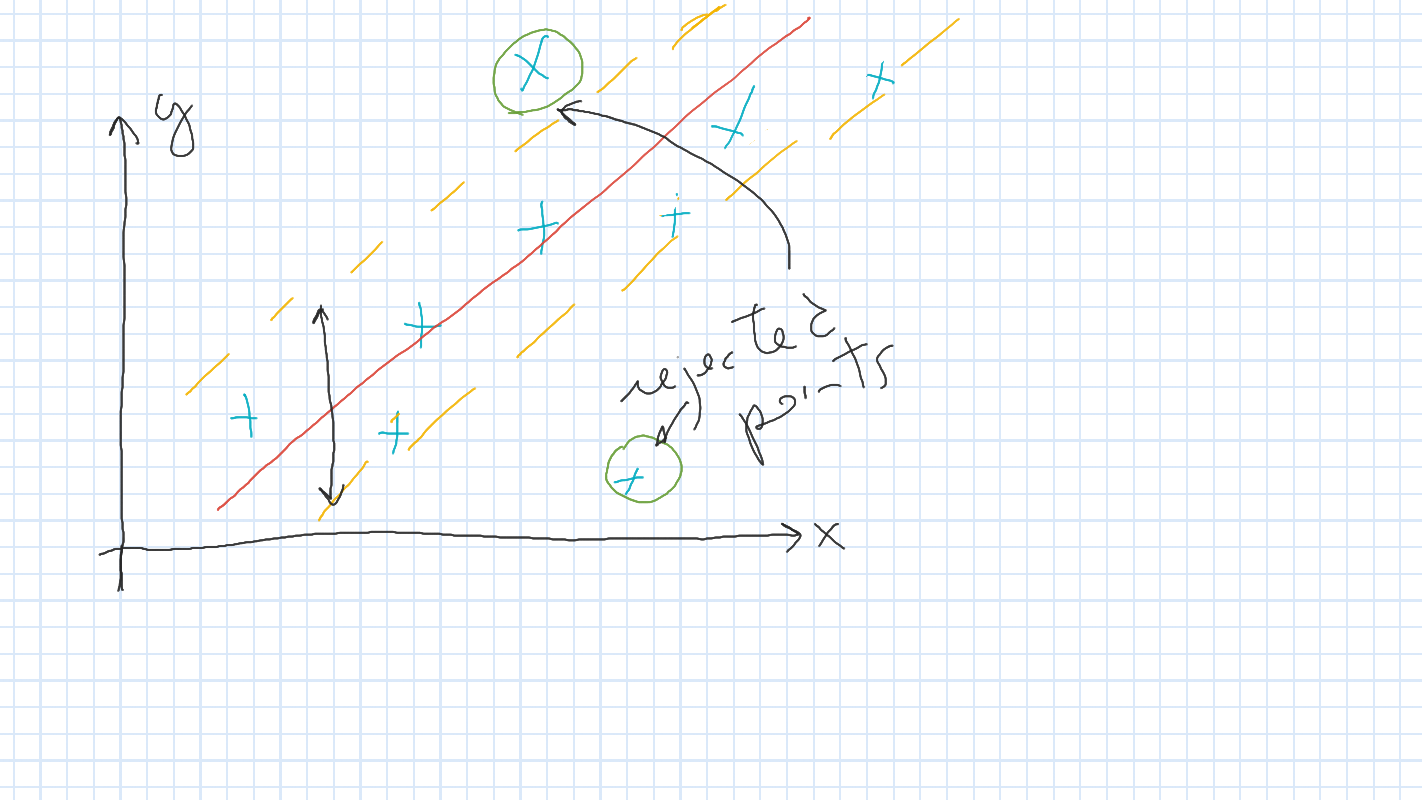

## Huber loss function
An example of an M estimator that is common in robust regression is that of the
Huber loss (or cost) function. The Huber estimator minimizes

$$\sum_{i=1}^{N} e(y_i|y)$$

where $e(y_i |y)$ is modeled as

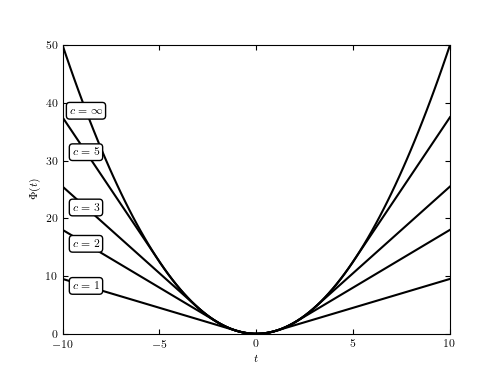

and $t = y_i − y$ with a constant c that must be chosen. The Huber function is equivalent to
assuming a Gaussian error distribution for small excursions from the true value of the function and an exponential distribution for large excursions (its behavior is a compromise between the mean and the median).

## Bayesian Outlier Methods
From a Bayesian perspective, one can use the techniques developed within the context of a regression model in order to account for, and even to individually identify outliers. 

Figure again shows the data set previusly
used, which contains three clear outliers. In a standard straight-line fit to the data, the result is strongly affected by these points. Though this standard linear regression problem is solvable in closed form, here we compute the best-fit slope and intercept using MCMC sampling (and show the resulting contours in the upper-right panel).

The remaining two panels show two different Bayesian strategies for accounting
for outliers. The main idea is to enhance the model such that it can naturally explain
the presence of outliers. In the first model, we account for the outliers through the use
of a mixture model, adding a background Gaussian component to our data.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, inter]
100%|██████████| 6000/6000 [00:07<00:00, 830.58it/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, inter, log_sigmab, Yb, Pb]
100%|██████████| 6000/6000 [00:17<00:00, 347.30it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [theta, inter, log_sigmab, Yb, Pb]
>BinaryGibbsMetropolis: [qi]
100%|██████████| 6000/6000 [00:26<00:00, 229.24it/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


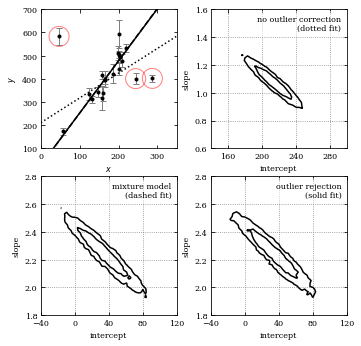

In [15]:
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np

import pymc3 as pm

from matplotlib import pyplot as plt
from theano import shared as tshared
import theano.tensor as tt

from astroML.datasets import fetch_hogg2010test
from astroML.plotting.mcmc import convert_to_stdev


# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

np.random.seed(0)

# ------------------------------------------------------------
# Get data: this includes outliers. We need to convert them to Theano variables
data = fetch_hogg2010test()
xi = tshared(data['x'])
yi = tshared(data['y'])
dyi = tshared(data['sigma_y'])
size = len(data)


# ----------------------------------------------------------------------
# Define basic linear model

def model(xi, theta, intercept):
    slope = np.tan(theta)
    return slope * xi + intercept


# ----------------------------------------------------------------------
# First model: no outlier correction
with pm.Model():
    # set priors on model gradient and y-intercept
    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    y = pm.Normal('y', mu=model(xi, theta, inter), sd=dyi, observed=yi)

    trace0 = pm.sample(draws=5000, tune=1000)


# ----------------------------------------------------------------------
# Second model: nuisance variables correcting for outliers
# This is the mixture model given in equation 17 in Hogg et al
def mixture_likelihood(yi, xi):
    """Equation 17 of Hogg 2010"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    L_in = (1. / root2pi / dyi * np.exp(-0.5 * (yi - mu) ** 2 / Vi))

    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
             * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))

    return tt.sum(tt.log((1 - Pb) * L_in + Pb * L_out))


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -200, 400)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2, testval=np.pi / 4)

    y_mixture = pm.DensityDist('mixturenormal', logp=mixture_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace1 = pm.sample(draws=5000, tune=1000)


# ----------------------------------------------------------------------
# Third model: marginalizes over the probability that each point is an outlier.
# define priors on beta = (slope, intercept)

def outlier_likelihood(yi, xi):
    """likelihood for full outlier posterior"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    logL_in = -0.5 * tt.sum(qi * (np.log(2 * np.pi * Vi)
                                  + (yi - mu) ** 2 / Vi))

    logL_out = -0.5 * tt.sum((1 - qi) * (np.log(2 * np.pi * (Vi + Vb))
                                         + (yi - Yb) ** 2 / (Vi + Vb)))

    return logL_out + logL_in


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    # qi is bernoulli distributed
    qi = pm.Bernoulli('qi', p=1 - Pb, shape=size)

    y_outlier = pm.DensityDist('outliernormal', logp=outlier_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace2 = pm.sample(draws=5000, tune=1000)


# ------------------------------------------------------------
# plot the data
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.1, top=0.95, hspace=0.2)

# first axes: plot the data
ax1 = fig.add_subplot(221)
ax1.errorbar(data['x'], data['y'], data['sigma_y'], fmt='.k', ecolor='gray', lw=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

#------------------------------------------------------------
# Go through models; compute and plot likelihoods
linestyles = [':', '--', '-']
labels = ['no outlier correction\n(dotted fit)',
          'mixture model\n(dashed fit)',
          'outlier rejection\n(solid fit)']

x = np.linspace(0, 350, 10)

bins = [(np.linspace(140, 300, 51), np.linspace(0.6, 1.6, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51))]

for i, trace in enumerate([trace0, trace1, trace2]):
    H2D, bins1, bins2 = np.histogram2d(np.tan(trace['theta']),
                                       trace['inter'], bins=50)
    w = np.where(H2D == H2D.max())

    # choose the maximum posterior slope and intercept
    slope_best = bins1[w[0][0]]
    intercept_best = bins2[w[1][0]]

    # plot the best-fit line
    ax1.plot(x, intercept_best + slope_best * x, linestyles[i], c='k')

    # For the model which identifies bad points,
    # plot circles around points identified as outliers.
    if i == 2:
        Pi = trace['qi'].mean(0)
        outlier_x = data['x'][Pi < 0.32]
        outlier_y = data['y'][Pi < 0.32]
        ax1.scatter(outlier_x, outlier_y, lw=1, s=400, alpha=0.5,
                    facecolors='none', edgecolors='red')

    # plot the likelihood contours
    ax = plt.subplot(222 + i)

    H, xbins, ybins = np.histogram2d(trace['inter'],
                                     np.tan(trace['theta']), bins=bins[i])
    H[H == 0] = 1E-16
    Nsigma = convert_to_stdev(np.log(H))

    ax.contour(0.5 * (xbins[1:] + xbins[:-1]),
               0.5 * (ybins[1:] + ybins[:-1]),
               Nsigma.T, levels=[0.683, 0.955], colors='black')

    ax.set_xlabel('intercept')
    ax.set_ylabel('slope')
    ax.grid(color='gray')
    ax.xaxis.set_major_locator(plt.MultipleLocator(40))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

    ax.text(0.96, 0.96, labels[i], ha='right', va='top',
            bbox=dict(fc='w', ec='none', alpha=0.5),
            transform=ax.transAxes)
    ax.set_xlim(bins[i][0][0], bins[i][0][-1])
    ax.set_ylim(bins[i][1][0], bins[i][1][-1])

ax1.set_xlim(0, 350)
ax1.set_ylim(100, 700)

plt.show()

# Gaussian Process Regression
Another powerful class of regression algorithms is Gaussian process regression.
Despite its name, Gaussian process regression is widely applicable to data that are not
generated by a Gaussian process, and can lead to very flexible regression models that
are more data driven than other parametric approaches. There is a rich literature on
the subject, and we will only give a cursory treatment here. An excellent book-length
treatment of Gaussian processes can be found in
http://www.gaussianprocess.org/gpml/chapters/RW.pdf.


A Gaussian process is a collection of random variables in parameter space, any
subset of which is defined by a joint Gaussian distribution. It can be shown that a
Gaussian process can be completely specified by its mean and covariance function.
Gaussian processes can be defined in any number of dimensions for any positive
covariance function. For simplicity, in this section we will consider one dimension
and use a familiar squared-exponential covariance function,

$$Cov(x_1, x_2; h)=exp(\frac{-(x_1-x_2)^2}{2h^2})$$

where $h$ is the bandwidth. Given a chosen value of $h$, this covariance function
specifies the statistics of an infinite set of possible functions $f(x)$. The upper-left
panel of figure 10 shows three of the possible functions drawn from a zero-mean
Gaussian process with h = 1.0. 




This becomes more interesting when we specify
constraints on the Gaussian process: that is, we select only those functions f (x) which pass through particular points in the space. The remaining panels of the figure show this Gaussian process constrained by points without error (upper-right panel), points with error (lower-left panel), and a set of 20 noisy observations drawn from the function $f_{true} (x) = cos x$. In each, the shaded region shows the $2\sigma$ contour in which 95% of all possible functions $f(x)$ lie.

These constrained Gaussian process examples hint at how these ideas could be used for standard regression tasks. The Gaussian process regression problem can be formulated similarly to the other regression problems discussed above. We assume our data is drawn from an underlying model $f(x)$: that is, our observed data is {$x_i , y_i = f (x_i ) + \sigma_i$}. Given the observed data, we desire an estimate of the mean value $f̄_j^∗$ and variance $\Sigma^∗_{jk}$ for a new set of measurements $x^∗_j$. In Bayesian terms, we want to compute the posterior pdf

$$p(f_j^*| \{x_i, y_i, \sigma_i \}, x_j^*)$$


best-fit theta = 0.506933422889602


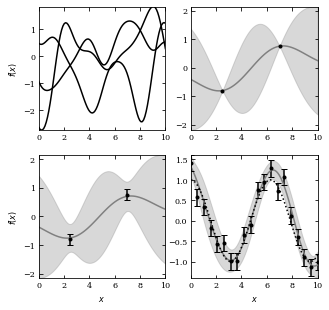

In [16]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.optimize import fmin_cobyla

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


#------------------------------------------------------------
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

#------------------------------------------------------------
# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 10, 100)
h = 1.0

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

#------------------------------------------------------------
# Constrain the mean and covariance with two points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)
kernel1 = kernels.RBF(1/0.5, (1/0.5, 1/0.5))
gp1 = GaussianProcessRegressor(kernel=kernel1, random_state=0, normalize_y=True)
gp1.fit(x1[:, None], y1)
f1, f1_err = gp1.predict(x[:, None], return_std=True)

#------------------------------------------------------------
# Constrain the mean and covariance with two noisy points
#  scikit-learn gaussian process uses nomenclature from the geophysics
#  community, where a "nugget (alpha parameter)" can be specified.
#  The diagonal of the assumed covariance matrix is multiplied by the nugget.
#  This is how the error on inputs is incorporated into the calculation.
dy2 = 0.2
kernel2 = kernels.RBF(1/0.5, (1/0.5, 1/0.5))
gp2 = GaussianProcessRegressor(kernel=kernel2,
                               alpha=(dy2 / y1) ** 2, random_state=0)
gp2.fit(x1[:, None], y1)
f2, f2_err = gp2.predict(x[:, None], return_std=True)


#------------------------------------------------------------
# Constrain the mean and covariance with many noisy points
x3 = np.linspace(0, 10, 20)
y3 = np.cos(x3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)

kernel3 = kernels.RBF(0.5, (0.01, 10.0))
gp3 = GaussianProcessRegressor(kernel=kernel3,
                               alpha=(dy3 / y3) ** 2, random_state=0)
gp3.fit(x3[:, None], y3)
f3, f3_err = gp3.predict(x[:, None], return_std=True)

# we have fit for the `h` parameter: print the result here:
print("best-fit theta =", gp3.kernel_.theta[0])


#------------------------------------------------------------
# Plot the diagrams
fig = plt.figure(figsize=(5, 5))


# first: plot a selection of unconstrained functions
ax = fig.add_subplot(221)
ax.plot(x, draws.T, '-k')
ax.set_ylabel('$f(x)$')

# second: plot a constrained function
ax = fig.add_subplot(222)
ax.plot(x, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * f1_err, f1 + 2 * f1_err, color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)


# third: plot a constrained function with errors
ax = fig.add_subplot(223)
ax.plot(x, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * f2_err, f2 + 2 * f2_err, color='gray', alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt='.k', ms=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

# third: plot a more constrained function with errors
ax = fig.add_subplot(224)
ax.plot(x, f3, '-', color='gray')
ax.fill_between(x, f3 - 2 * f3_err, f3 + 2 * f3_err, color='gray', alpha=0.3)
ax.errorbar(x3, y3, dy3, fmt='.k', ms=6)

ax.plot(x, np.cos(x), ':k')

ax.set_xlabel('$x$')

for ax in fig.axes:
    ax.set_xlim(0, 10)

plt.show()

This amounts to averaging over the entire set of possible functions f (x) which pass
through our constraints. This seemingly infinite calculation can be made tractable
using a “kernel trick,”, transforming from the infinite function space to a finite covariance space. The result of this mathematical exercise is that the Gaussian process regression problem can be formulated as follows.

Using the assumed form of the covariance function, we compute the
covariance matrix

$$K= 
\begin{pmatrix}
 K_{11} & K_{12} \\
 K_{12}^t & K_{22} \\
\end{pmatrix}$$

where $K_11$ is the covariance between the input points $x_i$ with observational errors
$\sigma_i^2$ added in quadrature to the diagonal, $K_{12}$ is the cross-covariance between the input points $x_i$ and the unknown points $x^∗_j$ , and $K_{22}$ is the covariance between the unknown points $x^∗_j$. Then for observed vectors $x$ and $y$, and a vector of unknown points $x^∗$, it can be shown that the posterior is given by

$$p(f_j|\{x_i, y_i, \sigma_i\}, x^*_j)=N(\mu, \sigma)$$

where:

$$\mu=K_{12}K_{11}^{-1}y$$

$$\Sigma=K_{22}-K_{12}^T K_{11}^{-1} K_{12}$$

Then $\mu_j$ gives the expected value $\bar{f}^*_j$ of the result, and $\Sigma_{jk}$ gives the error covariance between any two unknown points. Note that the physics of the underlying process
enters through the assumed form of the covariance function ( for an
analysis of several plausible covariance functions in the astronomical context of
quasar variability; see https://arxiv.org/abs/1202.3783).

In next figure, we show a Gaussian process regression analysis of the supernova
data set used above. The model is very well constrained near $z = 0.6$, where there is
a lot of data, but not well constrained at higher redshifts. This is an important feature
of Gaussian process regression: the analysis produces not only a best-fit model, but
an uncertainty at each point, as well as a full covariance estimate of the result at
unknown points.



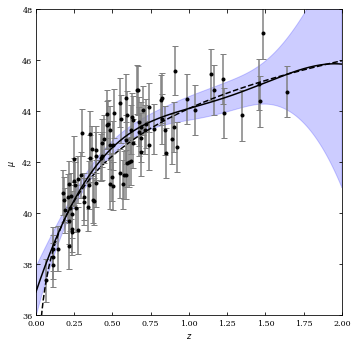

In [17]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from astropy.cosmology import LambdaCDM

from astroML.datasets import generate_mu_z

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

# ------------------------------------------------------------
# Generate data
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73, Tcmb0=0)
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0, cosmo=cosmo)

z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

# ------------------------------------------------------------
# fit the data
# Mesh the input space for evaluations of the real function,
# the prediction and its MSE
z_fit = np.linspace(0, 2, 1000)

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu ** 2)

gp.fit(z_sample[:, None], mu_sample)
y_pred, sigma = gp.predict(z_fit[:, None], return_std=True)

# ------------------------------------------------------------
# Plot the gaussian process
#  gaussian process allows computation of the error at each point
#  so we will show this as a shaded region
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
ax = fig.add_subplot(111)

ax.plot(z, mu_true, '--k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', markersize=6)
ax.plot(z_fit, y_pred, '-k')
ax.fill_between(z_fit, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                alpha=0.2, color='b', label='95% confidence interval')

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.set_xlim(0, 2)
ax.set_ylim(36, 48)

plt.show()

# Overfitting, Underfitting, and Cross-Validation
When using regression, whether from a Bayesian or maximum likelihood perspective, it is important to recognize some of the potential pitfalls associated with these methods. As noted above, the optimality of the regression is contingent on correct model selection. In this section we explore cross-validation methods which
can help determine whether a potential model is a good fit to the data. These techniques are complementary to the model selection techniques such as AIC and BIC. This section will introduce the important topics of overfitting and underfitting, bias and variance, and introduces the frequentist tool of cross-validation to understand these.

Here, for simplicity, we will consider the example of a simple one-dimensional
model with homoscedastic errors, though the results of this section naturally generalize to more sophisticated models. As above, our observed data is $x_i$, and we’re trying
to predict the dependent variable $y_i$. We
 have a training sample in which we have
observed both $x_i$ and $y_i$, and an unknown sample for which only $x_i$ is measured.

For example, you may be looking at the fundamental plane for elliptical galaxies,
and trying to predict a galaxy’s central black hole mass given the velocity dispersion
and surface brightness of the stars. Here $y_i$ is the mass of the black hole, and $x_i4
is a vector of a length two consisting of velocity dispersion and surface brightness
measurements.

Throughout the rest of this section, we will use a simple model where x and y satisfy the following:

$$0 \leq x_i \leq3$$

$$y_i=x_i sin(x_i)+ \epsilon_i$$

where the noise is drawn from a normal distribution $\epsilon_i ∼ N (0, 0.1)$. The values for 20 regularly spaced points are shown



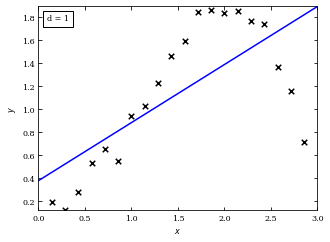

In [18]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# First figure: plot points with a linear fit
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

ax.scatter(x, y, marker='x', c='k', s=30)

p = np.polyfit(x, y, 1)
y_fit = np.polyval(p, x_fit)

ax.text(0.03, 0.96, "d = 1", transform=plt.gca().transAxes,
        ha='left', va='top',
        bbox=dict(ec='k', fc='w'))

ax.plot(x_fit, y_fit, '-b')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

We will start with a simple straight-line fit to our data. The model is described by two parameters, the slope of the line, $\theta_1$, and the y-axis intercept, $\theta_0$ , and is found by minimizing the mean square error,

$$\epsilon=\frac{1}{N}\sum_{i=1}^{N}(y_i-\theta_0+\theta_1 x_i)^2$$

The resulting best-fit line is shown in figure. It is clear that a straight line is not a good fit: it does not have enough flexibility to accurately model the data. We say in this case that the model is biased, and that it underfits the data.

What can be done to improve on this? One possibility is to make the model more sophisticated by increasing the degree of the polynomial. For example, we could fit a quadratic function, or a cubic function, or in general a d-degree polynomial. A more complicated model with more free parameters should be able to fit the data much more closely. The panels of next figure show the best-fit polynomial model for three different choices of the polynomial degree d.

As the degree of the polynomial increases, the best-fit curve matches the data points more and more closely. In the extreme of d = 19, we have 20 degrees of freedom with 20 data points, and the training error can be reduced to zero (though numerical issues can prevent this from being realized in practice).
Unfortunately, it is clear that the d = 19 polynomial is not a better fit to our data
as a whole: the wild swings of the curve in the spaces between the training points
are not a good description of the underlying data model. The model suffers from
high variance; it overfits the data. The term variance is used here because a small
perturbation of one of the training points in the d = 19 model can change the
best-fit model by a large magnitude. In a high-variance model, the fit varies strongly
depending on the exact set or subset of data used to fit it.

The center panel of figure shows a d = 3 model which balances the trade-off between bias and variance: it does not display the high bias of the d = 2 model, and does not display high variance like the d = 19 model. For simple two-dimensional data like that seen here, the bias/variance trade-off is easy to visualize by plotting the model along with the input data. But this strategy is not as fruitful as the number of data dimensions grows. What we need is a general measure of the “goodness of fit”
of different models to the training data. As displayed above, the mean square error
does not paint the whole picture: increasing the degree of the polynomial in this case
can lead to smaller and smaller training errors, but this reflects overfitting of the data
rather than an improved approximation of the underlying model.


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


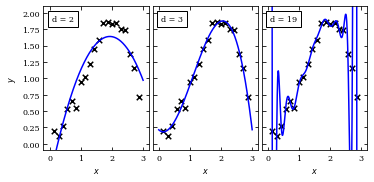

In [19]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Second figure: plot fit for several orders of polynomial
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(wspace=0.03, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for i, d in enumerate([2, 3, 19]):
    ax = fig.add_subplot(131 + i)
    ax.scatter(x, y, marker='x', c='k', s=30)

    p = np.polyfit(x, y, d)
    y_fit = np.polyval(p, x_fit)

    ax.plot(x_fit, y_fit, '-b')
    ax.set_ylim(-0.1, 2.1)
    ax.set_xlim(-0.2, 3.2)
    if i in (1, 2):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    ax.text(0.08, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w'))

plt.show()

# Cross-Validation
There are several possible approaches to cross-validation. We will discuss one
approach in detail here, and list some alternative approaches at the end of the section.
The simplest approach to cross-validation is to split the training data into three
parts: the training set, the cross-validation set, and the test set. As a rule of thumb,
the training set should comprise 50–70% of the original training data, while the
remainder is divided equally into the cross-validation set and test set.

The training set is used to determine the parameters of a given model (i.e., the
optimal values of $\theta_j$ for a given choice of d). Using the training set, we evaluate the
training error $\epsilon_{tr}$. The cross-validation set is used to evaluate the cross-validation error $\epsilon_{cv}$ of the model. Because this cross-validation set
was not used to construct the fit, the cross-validation error will be large for a high-
bias (overfit) model, and better represents the true goodness of fit of the model. With
this in mind, the model which minimizes this cross-validation error is likely to be
the best model in practice. Once this model is determined, the test error is evaluated
using the test set. This test error gives an estimate of the reliability of the model for an unlabeled data set.

Why do we need a test set as well as a cross-validation set? In one sense, just
as the parameters (in this case, $\theta_j$) are learned from the training set, the so-called
hyperparameters—those parameters which describe the complexity of the model (in this case, d)—are learned from the cross-validation set. In the same way that the parameters can be overfit to the training data, the hyperparameters can be overfit to the cross-validation data, and the cross-validation error gives an overly optimistic
estimate of the performance of the model on an unlabeled data set. The test error is
a better representation of the error expected for a new set of data. This is why it is
recommended to use both a cross-validation set and a test set in your analysis.

A useful way to use the training error and cross-validation error to evaluate
a model is to look at the results graphically. Figures hows the training error
and cross-validation error as a function of the polynomial degree d. For reference, the dotted line indicates the level of intrinsic scatter added to our data.

The broad features of this plot reflect what is generally seen as the complexity of a regression model is increased: for small d, we see that both the training error and cross-validation error are very high. This is the tell-tale indication of a high-bias model, in which the model underfits the data. Because the model does not have enough complexity to describe the intrinsic features of the data, it performs poorly for both the training and cross-validation sets.

For large d, we see that the training error becomes very small (smaller than the
intrinsic scatter we added to our data) while the cross-validation error becomes very
large. This is the telltale indication of a high-variance model, in which the model
overfits the data. Because the model is overly complex, it can match subtle variations
in the training set which do not reflect the underlying distribution. Plotting this sort
of information is a very straightforward way to settle on a suitable model. Of course, AIC and BIC provide another way to choose optimal d. Here both methods would choose the model with the best possible cross-validation error: d = 3


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


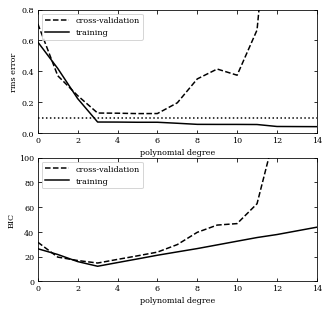

In [20]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Third figure: plot errors as a function of polynomial degree d
d = np.arange(0, 21)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

fig = plt.figure(figsize=(5, 5))
for i in range(len(d)):
    p = np.polyfit(x, y, d[i])
    training_err[i] = np.sqrt(np.sum((np.polyval(p, x) - y) ** 2)
                              / len(y))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, x_cv) - y_cv) ** 2)
                              / len(y_cv))

BIC_train = np.sqrt(len(y)) * training_err / dy + d * np.log(len(y))
BIC_crossval = np.sqrt(len(y)) * crossval_err / dy + d * np.log(len(y))

ax = fig.add_subplot(211)
ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')
ax.plot(d, 0.1 * np.ones(d.shape), ':k')

ax.set_xlim(0, 14)
ax.set_ylim(0, 0.8)

ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc=2)

ax = fig.add_subplot(212)
ax.plot(d, BIC_crossval, '--k', label='cross-validation')
ax.plot(d, BIC_train, '-k', label='training')

ax.set_xlim(0, 14)
ax.set_ylim(0, 100)

ax.legend(loc=2)
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')

plt.show()

## Learning Curves
One question that cross-validation does not directly address is that of how to improve
a model that is not giving satisfactory results (e.g., the cross-validation error is much
larger than the known errors). There are several possibilities:
1. Get more training data. Often, using more data to train a model can lead to
better results. Surprisingly, though, this is not always the case.
2. Use a more/less complicated model. As we saw above, the complexity of a
model should be chosen as a balance between bias and variance.
3. Use more/less regularization. Including regularization, as we saw in the
discussion of ridge regression (see § 8.3.1) and other methods above, can help with the bias/variance trade-off. In general, increasing regularization has a
similar effect to decreasing the model complexity.
4. Increase the number of features. Adding more observations of each object in
your set can lead to a better fit. But this may not always yield the best results.

The choice of which route to take is far beyond a simple philosophical matter: for example, if you desire to improve your photometric redshifts for a large astronomical survey, it is important to evaluate whether you stand to benefit more from increasing the size of the training set (i.e., gathering spectroscopic redshifts for more galaxies) or from increasing the number of observations of each galaxy (i.e., reobserving
the galaxies through other passbands). The answer to this question will inform the
allocation of limited, and expensive, telescope time.
 
Note that this is a fundamentally different question than that explored above.
There, we had a fixed data set, and were trying to determine the best model. Here,
we assume a fixed model, and are asking how to improve the data set. One way to
address this question is by plotting learning curves. A learning curve is the plot of the
training and cross-validation error as a function of the number of training points.
The details are important, so we will write this out explicitly. 

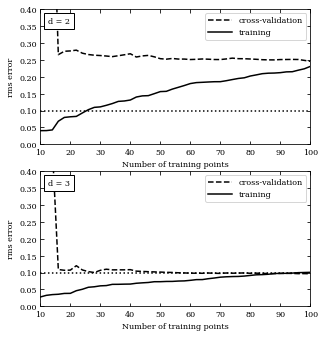

In [21]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Fourth figure: plot errors as a function of training set size
np.random.seed(0)
x = 3 * np.random.random(100)
y = func(x)

np.random.seed(1)
x_cv = 3 * np.random.random(100)
y_cv = func(x_cv)

Nrange = np.arange(10, 101, 2)

fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.15, top=0.95)

for subplot, d in zip([211, 212], [2, 3]):
    ax = fig.add_subplot(subplot)
    training_err = np.zeros(Nrange.shape)
    crossval_err = np.zeros(Nrange.shape)

    for j, N in enumerate(Nrange):
        p = np.polyfit(x[:N], y[:N], d)
        training_err[j] = np.sqrt(np.sum((np.polyval(p, x[:N])
                                          - y[:N]) ** 2) / len(y))
        crossval_err[j] = np.sqrt(np.sum((np.polyval(p, x_cv)
                                          - y_cv) ** 2) / len(y_cv))

    ax.plot(Nrange, crossval_err, '--k', label='cross-validation')
    ax.plot(Nrange, training_err, '-k', label='training')
    ax.plot(Nrange, 0.1 * np.ones(Nrange.shape), ':k')
    ax.legend(loc=1)
    ax.text(0.03, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='k', fc='w'))

    ax.set_ylim(0, 0.4)

    ax.set_xlabel('Number of training points')
    ax.set_ylabel('rms error')

plt.show()

The two panels show some common features, which are reflective of the features
of learning curves for any regression model:
1. As we increase the size of the training set, the training error increases. The
reason for this is simple: a model of a given complexity can better fit a small
set of data than a large set of data. Moreover, aside from small random
fluctuations, we expect this training error to always increase with the size of
the training set.
2. As we increase the size of the training set, the cross-validation error decreases.
The reason for this is easy to see: a smaller training set leads to overfitting the
model, meaning that the model is less representative of the cross-validation
data. As the training set grows, overfitting is reduced and the cross-validation
error decreases. Again, aside from random fluctuations, and as long as the
training set and cross-validation set are statistically similar, we expect the
cross-validation error to always decrease as the training set size grows.
3. The training error is everywhere less than or equal to the cross-validation
error, up to small statistical fluctuations. We expect the model on average to
better describe the data used to train it.
4. The logical outcome of the above three observations is that as the size N of
the training set becomes large, the training and cross-validation curves will
converge to the same value.

To summarize, plotting learning curves can be very useful for evaluating the
efficiency of a model and potential paths to improving your data. There are two
possible situations:

1. The training error and cross-validation error have converged. In this case,
increasing the number of training points under the same model is futile: the
error cannot improve further. This indicates a model error dominated by
bias (i.e., it is underfitting the data). For a high-bias model, the following
approaches may help:
 - Add additional features to the data.
 - Increase the model complexity.
 - Decrease the regularization.

2. The training error is much smaller than the cross-validation error. In this
case, increasing the number of training points is likely to improve the model.
This condition indicates that the model error is dominated by variance (i.e., it
is overfitting the data). For a high-variance model, the following approaches
may help:
  - Increase the training set size.
  - Decrease the model complexity.
  - Increase the amplitude of the regularization.


## Other Cross-Validation Techniques
There are numerous cross-validation techniques available which are suitable for different situations. It is easy to generalize from the above discussion to these various cross-validation strategies, so we will just briefly mention them here.

- Twofold cross-validation

Above, we split the data into a training set d 1 , a cross-validation set d 2 , and a test set
d 0 . Our simple tests involved training the model on d 0 and cross-validating the model
on d 1 . In twofold cross-validation, this process is repeated, training the model on d 1
and cross-validating the model on d 0 . The training error and cross-validation error
are computed from the mean of the errors in each fold. This leads to more robust
determination of the cross-validation error for smaller data sets.
 
 - K fold cross-validation

A generalization of twofold cross-validation is K -fold cross-validation. Here we split
the data into K + 1 sets: the test set $d_0$ , and the cross-validation sets $d_1, d_2, . . . , d_K$. We train K different models, each time leaving out a single subset to measure the
cross-validation error. The final training error and cross-validation error can be
computed using the mean or median of the set of results. The median can be a better
statistic than the mean in cases where the subsets $d_i$ contain few points.

 - Leave-one-out cross-validation

At the extreme of K -fold cross-validation is leave-one-out cross-validation. This is
essentially the same as K -fold cross-validation, but this time our sets $d_1 , d_2, . . . , d_K$ have only one data point each. That is, we repeatedly train the model, leaving out only a single point to estimate the cross-validation error. Again, the final training error and cross-validation error are estimated using the mean or median of the individual trials. This can be useful when the size of the data set is very small, so that significantly reducing the number of data points leads to much different model characteristics.

 - Random subset cross-validation

In this approach, the cross-validation set and training set are selected by randomly
partitioning the data, and repeating any number of times until the error statistics are
well sampled. The disadvantage here is that not every point is guaranteed to be used
both for training and for cross-validation. Thus, there is a finite chance that an outlier
can lead to spurious results. For N points and P random samplings of the data, this
situation becomes very unlikely for $N/2^p  << 1$.

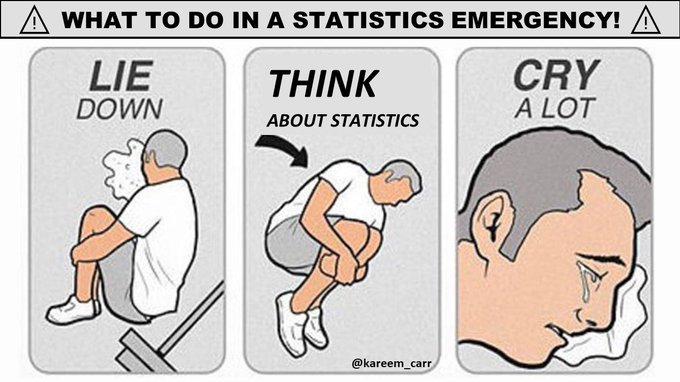

In [12]:
!pip install astroML